#### El objetivo de este proyecto es clasificar casas segun donde se encuentren y el ingreso medio, se trabajara con el data set de California Housing
- Se construyó utilizando los datos del censo de California de 1990. Contiene una fila por grupo de bloques censales. Un grupo de bloques es la unidad geográfica más pequeña para la que se publican datos del censo de USA.

# EDA

### Carga de datos
- Cargaré los datos de un url utilizando la funcion pd.read_csv de pandas.

In [103]:
# Importo la libreria pandas para cargar los datos.
import pandas as pd

data = pd.read_csv('https://breathecode.herokuapp.com/asset/internal-link?id=809&path=housing.csv')


# Con este script solo guardo el DataFrame de pandas para tener fisicamente los datos
data.to_csv('../data/raw/data_raw.csv')
print('Datos guardados en data/raw correctamente')

Datos guardados en data/raw correctamente


In [104]:
# Utilizo head para observar las primeras 10 filas del conjunto de datos y ver el nombre de las columnas que lo conforman
data.head(10)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
5,4.0368,52.0,4.761658,1.103627,413.0,2.139896,37.85,-122.25,2.697
6,3.6591,52.0,4.931907,0.951362,1094.0,2.128405,37.84,-122.25,2.992
7,3.1200,52.0,4.797527,1.061824,1157.0,1.788253,37.84,-122.25,2.414
8,2.0804,42.0,4.294118,1.117647,1206.0,2.026891,37.84,-122.26,2.267
9,3.6912,52.0,4.970588,0.990196,1551.0,2.172269,37.84,-122.25,2.611


- Como el objetivo es clasificar casas según su ubicacion y el ingreso medio, solo trabajaré con las columnas que sean relevantes al objetivo.
-
- En este caso solo nos interesan las columnas Latitude, Longitude, MedInc.

- Por lo que el siguiente paso es eliminar el resto, para ello creare una copia de la data unicamente con esas columnas, y sobre esa copia trabajaré.

In [105]:
# Selecciono las columnas que me interesan.
data_copy = data[['Latitude', 'Longitude', 'MedInc']]
# Ahora visualizo las 10 primeras filas del nuevo data frame
data_copy.head(10)

,Latitude,Longitude,MedInc
0,37.88,-122.23,8.3252
1,37.86,-122.22,8.3014
2,37.85,-122.24,7.2574
3,37.85,-122.25,5.6431
4,37.85,-122.25,3.8462
5,37.85,-122.25,4.0368
6,37.84,-122.25,3.6591
7,37.84,-122.25,3.1200
8,37.84,-122.26,2.0804
9,37.84,-122.25,3.6912


### Limpieza de datos
- Una vez seleccionadas las columnas es momento de buscar valores nulos oh duplicados para que el modelo pueda trabajar con ellas.
- Utilizaré .isnull().sum() para ver la suma de los nulos.
- Utilizaré .duplicated() para ver aquellos valores duplicados.

In [106]:
# Buscar valores nulos
data_copy.isnull().sum()

Latitude     0
Longitude    0
MedInc       0
dtype: int64

No se detectaron valores nulos, ahora procederé a buscar duplicados.

In [107]:
# Buscar duplicados
data_copy.duplicated().sum()


np.int64(5)

In [108]:
# Elimino los 5 duplicados utilizando .drop_duplicates()
data_copy = data_copy.drop_duplicates()

In [109]:
data_copy.duplicated().sum()

np.int64(0)

### Ingenieria de caracteristicas
- Como utilizaremos el modelo KMean, para clustering, primero es necesario escalar y reducir la dimensionalidad de la data.
- Para ello primero utilizaré StandarScaled para llevar a todas las columnas a una desviacion estandar entre 0 y 1, asi podemos evitar outliers
- Una vez escalados los datos entrenaré el modelo KMeans
- Debido a que unicamente me quede con 3 columnas no reducire la dimensionalidad usando PCA, primero probaré el algoritmo con esas 3 columnas y lo utilizaré posterior para comparar los resultados.

In [110]:
# Importo la libreria que contiene el algoritmo StandarScaler()
from sklearn.preprocessing import StandardScaler

# Creo el escalador scaler
scaler = StandardScaler()

# Entreno la data con el escalador
scaler.fit(data_copy)

# Genero un nuevo data set con la data escalada
data_scaled = scaler.transform(data_copy)

# Visualizo la nueva data, esta se compone en 3 columnas 0, 1, 2
data_scaled


array([[ 1.0524197 , -1.32767173,  2.35121759],
       [ 1.04305633, -1.32268076,  2.33865974],
       [ 1.03837465, -1.33266271,  1.78780259],
       ...,
       [ 1.77808043, -0.82358342, -1.1445092 ],
       [ 1.77808043, -0.87349315, -1.05628763],
       [ 1.74999034, -0.83356536, -0.78117564]], shape=(20635, 3))

Ahora entrenare el algoritmo KMeans para obtener el mejor agrupamiento (k), para ello utilizaré el metodo de codo, que practicamente consiste en iterar sobre un numero de clusters por ejemplo 10 y almacenar el resultado en una lista, sobre esa lista evaluare cual dio mejor resultado y me quedare con esa K

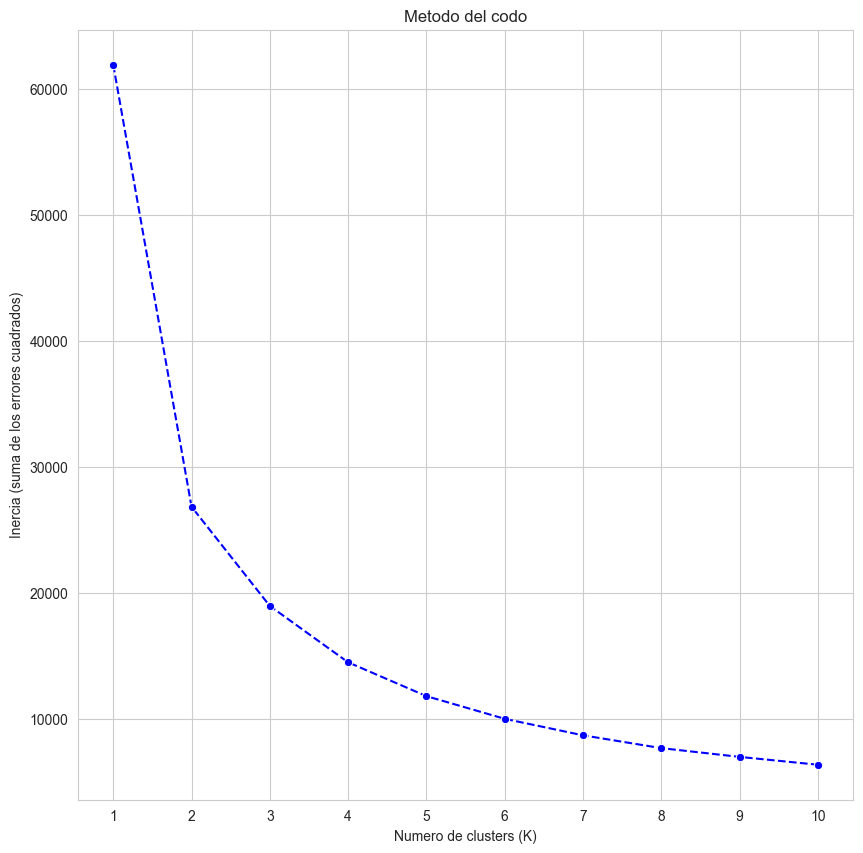

In [111]:
# Importo la libreria para poder ejecutar el modelo
# Importare matplotlib y seabron para graficar y ver donde la curva deja de caer bruscamente (el codo), ahi encontraré mi k optima
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

# Creo una lista donde se almacenaran las k
k_list = []
k_range = range(1,11)
for k in k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(data_scaled)
    k_list.append(km.inertia_)

# Grafico el codo
sns.set_style('whitegrid') # Mi tema favorito para graficos

plt.figure(figsize=(10,10))
sns.lineplot(x=k_range, y=k_list, marker='o', linestyle='--', color='b')
plt.title('Metodo del codo')
plt.xlabel('Numero de clusters (K)')
plt.ylabel('Inercia (suma de los errores cuadrados)')
plt.xticks(k_range) # Para asegurarnos que aparezcan todos los k
plt.show()


Visualmente podemos observar que en el cluster 3 (K = 3) la curva no decae radicalemente, por lo que se puede tomar como buena referencia para elegir el numero de clusters

### Dividir data de entrenamiento
- Dado que el objetivo es encontrar la variable 'y', de momento no tenemos la variable objetivo "y", solo dividire las caracteristicas

In [112]:
from sklearn.model_selection import train_test_split

# Divido la data de entrenamiento de las caracteristicas
X_train, X_test = train_test_split(data_copy, test_size=0.2, random_state=42)


### Creando flujo Pipeline para evitar fuga de datos
- Utilizo Pipeline de sklearn para entrenar el modelo y evitar fuga de datos
- K-Means es sensible a la escala de los datos.
 - Las coordenadas (Lat/Lon) y el ingreso (MedInc) no son comparables.

- Crearé un pipeline que primero escale los datos con StandardScaler y luego aplique KMeans con n_clusters=3.

- Entrenaré este pipeline usando solo el conjunto de entrenamiento.

In [113]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate

# Establezco la variable para crear el flujo
KMean_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('kmeans', KMeans(n_clusters=3, random_state=42, n_init=10))
])
# Entreno el pipeline solo con los datos de entrenamiento
KMean_pipeline.fit(X_train)

,steps,"[('scaler', ...), ('kmeans', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,n_clusters,3
,init,'k-means++'
,n_init,10
,max_iter,300


### Grafico de clusters (Train y Test)
- Una vez entrenado el pipeline, lo usaré para predecir el cluster al que pertenece cada punto en el set de entrenamiento.

- Luego, usaré el mismo pipeline (ya entrenado) para predecir los clusters en el set de prueba.

- Graficaré los resultados usando un scatterplot. La posición (x, y) vendrá de Longitude y Latitude, y el color vendrá de la etiqueta del cluster.

Observaremos si los clusters tienen sentido geográfico y cómo se distribuyen los puntos de prueba entre ellos.

In [114]:
# Obtengo las etiquetas para la visualizacion de train
train_labels = KMean_pipeline.predict(X_train)
X_train_clustered = X_train.copy()
X_train_clustered['cluster'] = train_labels
# Obtengo las etiquietas para la visualizacion de test
test_labels = KMean_pipeline.predict(X_test)
X_test_clustered = X_test.copy()
X_test_clustered['cluster'] = test_labels

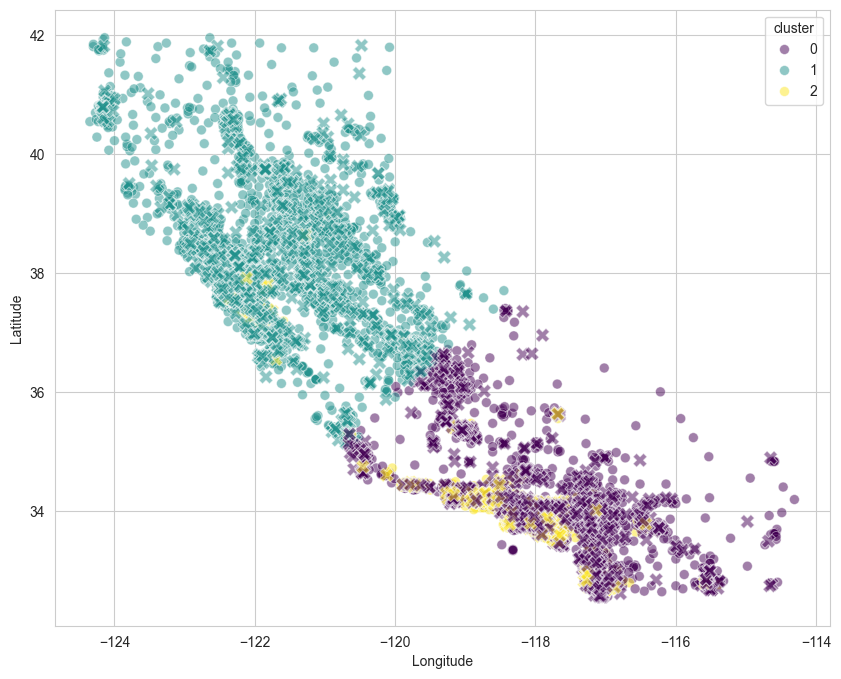

In [115]:
plt.figure(figsize=(10,8))
sns.scatterplot(
    data=X_train_clustered,
    x='Longitude',
    y='Latitude',
    hue='cluster',
    palette='viridis',
    s=50,
    alpha=0.5
)
sns.scatterplot(
    data=X_test_clustered,
    x='Longitude',
    y='Latitude',
    hue='cluster',
    palette='viridis',
    s=100,
    legend= False,
    marker='X',
    alpha=0.5
)
plt.show()

**Interpretación**
- El gráfico muestra la distribución geográfica de los clusters.

- División Geográfica Clara, los clusters tienen una fuerte base geográfica. Podemos ver agrupaciones que corresponden a regiones como el sur de California, el área de la bahía/costa norte y el valle central. Esto se debe a que Latitude y Longitude fueron entradas clave y tambien se vieron fuertemente influenciadas por la variable (MedInc) que separa los clusters dentro de la misma área geografica, por ejemplo, es probable que los clusters costeros (conocidos por ingresos más altos) se hayan separado de los clusters interiores, aunque estén a una latitud similar.

- Validación del Conjunto de Prueba: Los puntos de prueba (marcados con una 'X') encajan perfectamente dentro de las regiones de color definidas por los datos de entrenamiento. Esto es una excelente señal: significa que el modelo K-Means no solo memorizó los datos de entrenamiento, sino que aprendió límites regionales estables y es capaz de clasificar correctamente datos nuevos.

### Entrenar modelo supervisado
- El objetivo es entrenar un modelo que pueda predecir el cluster basándose en Latitude, Longitude y MedInc.

- Usaré las etiquetas generadas (0-3) como nuestra variable objetivo (y).

- Paso de Validación (CV): Antes de entrenar el modelo final, usaré cross_val_score con 5 folds (cv=5) sobre el conjunto de entrenamiento, esto nos dará una media de precisión y una desviación estándar, lo cual es una medida mucho más robusta de rendimiento que un solo accuracy_score.

- Entrenamiento Final: Después de validar, entrenaré el RandomForestClassifier en el conjunto completo de entrenamiento para evaluarlo en el conjunto de prueba.

In [116]:
# Ahora preparamos los datos para el modelo supervisado
# La 'y' es la etiqueta de cluster que acabamos de crear

# Datos de entrenamiento supervisado
X_sup_train = X_train_clustered.drop('cluster', axis=1)
y_sup_train = X_train_clustered['cluster']

# Datos de prueba supervisado
X_sup_test = X_test_clustered.drop('cluster', axis=1)
y_sup_test = X_test_clustered['cluster']

In [117]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import numpy as np
model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

cv_scores = cross_val_score(model, X_sup_train, y_sup_train,
                            cv=5, scoring='accuracy', n_jobs=-1)

print(f"Scores de Accuracy por fold: {np.round(cv_scores, 4)}")
print(f"Accuracy Media (CV): {cv_scores.mean():.4f}")
print(f"Desviación Estándar (CV): {cv_scores.std():.4f}")

# Entreno el modelo.
model.fit(X_sup_train, y_sup_train)
y_pred = model.predict(X_sup_test)


Scores de Accuracy por fold: [0.9979 0.9961 0.9949 0.9958 0.997 ]
Accuracy Media (CV): 0.9963
Desviación Estándar (CV): 0.0010


Evaluacion del modelo

In [118]:
from sklearn.metrics import classification_report, accuracy_score
accuracy = accuracy_score(y_sup_test, y_pred)
report = classification_report(y_sup_test, y_pred)

print(f"\n--- Evaluación del Modelo Supervisado (Random Forest) ---")
print(f"Accuracy (Precisión) en conjunto de prueba: {accuracy:.4f}")
print("\nReporte de Clasificación:")
print(report)


--- Evaluación del Modelo Supervisado (Random Forest) ---
Accuracy (Precisión) en conjunto de prueba: 0.9971

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2046
           1       1.00      1.00      1.00      1640
           2       0.99      0.99      0.99       441

    accuracy                           1.00      4127
   macro avg       1.00      1.00      1.00      4127
weighted avg       1.00      1.00      1.00      4127



In [119]:
import pickle
# Guardar el pipeline de K-Means (incluye el scaler)
model_kmeans_path = '../models/kmeans_pipeline.pkl'
pickle.dump(KMean_pipeline, open(model_kmeans_path, 'wb'))
print(f"\nModelo K-Means (pipeline) guardado correctamente en la carpeta models.")


Modelo K-Means (pipeline) guardado correctamente en la carpeta models.


In [120]:
# Guardar modelo RandomForest

pickle.dump(model, open('../models/model_random_forest.pkl', 'wb'))
print("Modelo RandomForest guardado correctamente en la carpeta models.")

Modelo RandomForest guardado correctamente en la carpeta models.


# Conclusiones
- El modelo K-Means logró segmentar geográficamente las viviendas, con MedInc probablemente influyendo en la separación de clusters costeros vs. interiores.

- El modelo RandomForestClassifier obtuvo una precisión muy alta, indicando que las tres variables de entrada son suficientes para predecir de manera confiable el segmento (cluster) al que pertenece una vivienda.